In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
class PDCDP:
    def __init__(self, lmbda: float, parts: int) -> None:
        self.parts = parts
        self.lmbda = lmbda
        self.maxiter = 100

    def fit(self, X):
        self.num_clusters = 1
        self.labels = np.zeros(len(X))
        self.centroids = X[np.random.choice(X.shape[0], self.num_clusters, replace=False)]
        splitted_x = np.array_split(X, self.parts) #p by (num_items_in_part_p by d)
        num_items_in_part_p = [len(x_p) for x_p in splitted_x] # 1 by p
        pool = multiprocessing.Pool()
        processes = [pool.apply_async(self.squared_l2, 
                                        args=(splitted_x[i],)) 
                                        for i in range(self.parts)]
        S_p = [p.get() for p in processes] # p by (num_items_in_part_p by 1)

        for _ in range(self.maxiter):
            i_max = np.ones(self.parts)*-1
            d_max = np.ones(self.parts)*-1
            pool = multiprocessing.Pool()
            processes = (pool.apply_async(self.do_in_parallel, 
                                          args=(splitted_x[i],
                                                num_items_in_part_p[i],
                                                S_p[i],
                                                i_max[i], 
                                                d_max[i],)) for i in range(self.parts))
            result = [p.get() for p in processes]
            result0 = [result[i][0] for i in range(self.parts)]
            result1 = [result[i][1] for i in range(self.parts)]
            i_max = [result[i][2] for i in range(self.parts)]
            d_max = [result[i][3] for i in range(self.parts)]
            splitted_labels = [result[i][4] for i in range(self.parts)]
            cluster_contribution = np.sum(result0, axis=0)
            p_max = np.argmax(d_max)
            total_num_in_each_cluster = np.sum(result1, axis=0)
            if d_max[p_max] > self.lmbda:
                j = int(i_max[p_max])
                k = int(splitted_labels[p_max][j])
                cluster_contribution[k,:] = cluster_contribution[k,:] - splitted_x[p_max][j,:]
                total_num_in_each_cluster[k] -= 1
                self.num_clusters += 1
                splitted_labels[p_max][j] = self.num_clusters - 1
                cluster_contribution = np.append(cluster_contribution, splitted_x[p_max][j,:]).reshape(-1,2) ### 2nd change
            self.labels = np.concatenate(splitted_labels)
            total_num_in_each_cluster = np.unique(self.labels, return_counts= True)[1]
            this_iter_centers = np.array([cluster_contribution[k,:]/total_num_in_each_cluster[k] for k in range(self.num_clusters)])
            if np.all(this_iter_centers == self.centroids):
                break
            else:
                self.centroids = this_iter_centers
            


    def do_in_parallel(self, splitted_x, num_items_in_part_p, S_p, i_max, d_max)
        S_bar = ((self.centroids)**2).sum(axis=1) # K by 1
        M_p = np.zeros((self.num_clusters, 2)) # self.num_clusters by d
        N_M_p = np.zeros((self.num_clusters,1)) # k by 1
        Np_copies = np.array(list(S_bar)*len(splitted_x)).reshape(len(splitted_x),len(S_bar))
        D_p = -2*splitted_x.dot(self.centroids.T) + Np_copies # Np by K
        splitted_labels = np.argmin(D_p, axis=1)
        for j in range(num_items_in_part_p):
            k = int(splitted_labels[j])
            M_p[k,:] = M_p[k,:] + splitted_x[j,:]
            N_M_p[k] += 1
            if np.sqrt(D_p[j, k] + S_p[j]) > max(d_max, self.lmbda):
                d_max = np.sqrt(D_p[j, k] + S_p[j])
                i_max = j
        return M_p, N_M_p, i_max, d_max, splitted_labels

    def predict(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)     

    def squared_l2(self, batch):
        return (batch**2).sum(axis=1)

/tmp/ipykernel_9213/3734189287.py:50: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(this_iter_centers == self.centroids):


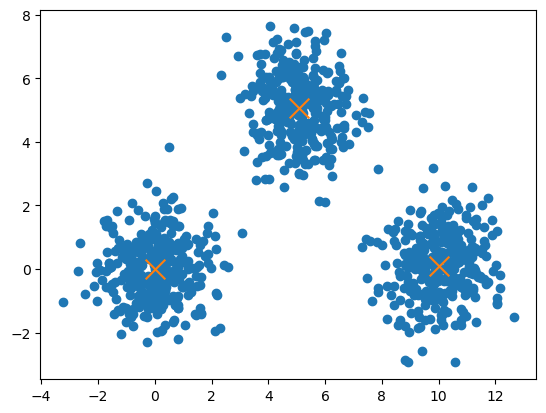

In [6]:
# Example usage
if __name__ =="__main__":
    np.random.seed(42)
    N = 1000
    K = 3
    means = np.array([[0, 0], [5, 5], [10, 0]])
    cov = np.eye(2)
    # this is a K by N array of random multivariate normal distributions
    X = np.vstack([np.random.multivariate_normal(mean, cov, int(N / K)) for mean in means])

    mini = PDCDP(7, 4)
    mini.fit(X)
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(mini.centroids[:,0], mini.centroids[:,1], marker='x', s=200)
    plt.show()